In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

from tensorflow.keras.layers import (Input, Layer, Dense, 
                                     experimental, Concatenate, 
                                     GlobalAveragePooling2D, Lambda)
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, Resizing
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

import os

#Select GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# IMPORTANT: SET RANDOM SEEDS FOR REPRODUCIBILITY
os.environ['PYTHONHASHSEED'] = str(420)
import random
random.seed(420)
np.random.seed(420)
tf.random.set_seed(420)

# Parameters

In [2]:
NUM_CLASSES = 5
BATCH_SIZE = 256
EPOCHS = 100
LR = 1e-3
INPUT_SHAPE = (544, 544, 3)

# Load Data

In [9]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'diabetic_retinopathy_detection/btgraham-300',
    split=['train', 'validation', 'test'],
    as_supervised=False,
    with_info=True,
)

### Get Label Counts

In [5]:
label_to_count = {0:0, 1:0, 2:0, 3:0, 4:0}
for entry in ds_train:
    label_to_count[entry['label'].numpy()] += 1

print("Training Set: ", label_to_count)

for k, v in label_to_count.items():
    label_to_count[k] = (label_to_count[k]/len(ds_train)) * 100

print("Training Set: ", label_to_count)

label_to_count = {0:0, 1:0, 2:0, 3:0, 4:0}
for entry in ds_test:
    label_to_count[entry['label'].numpy()] += 1

print("Test Set: ", label_to_count)

for k, v in label_to_count.items():
    label_to_count[k] = (label_to_count[k]/len(ds_test)) * 100

print("Test Set: ", label_to_count)

label_to_count = {0:0, 1:0, 2:0, 3:0, 4:0}
for entry in ds_val:
    label_to_count[entry['label'].numpy()] += 1

print("Val Set: ", label_to_count)

for k, v in label_to_count.items():
    label_to_count[k] = (label_to_count[k]/len(ds_val)) * 100

print("Val Set: ", label_to_count)

2022-04-16 22:58:50.189407: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-16 22:58:50.210479: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-04-16 22:58:50.214696: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-04-16 22:58:50.220259: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


Training Set:  {0: 25810, 1: 2443, 2: 5292, 3: 873, 4: 708}
Training Set:  {0: 73.47833513636623, 1: 6.954962136309287, 2: 15.06576325229175, 3: 2.48533849570119, 4: 2.0156009793315492}


2022-04-16 22:59:37.087015: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-04-16 22:59:37.091897: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-04-16 22:59:37.096581: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


Test Set:  {0: 31403, 1: 3042, 2: 6282, 3: 977, 4: 966}
Test Set:  {0: 73.59503163815327, 1: 7.129130536676823, 2: 14.722287321303023, 3: 2.2896648699320363, 4: 2.2638856339348488}


2022-04-16 23:00:33.623443: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-04-16 23:00:33.627421: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-04-16 23:00:33.633598: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


Val Set:  {0: 8130, 1: 720, 2: 1579, 3: 237, 4: 240}
Val Set:  {0: 74.54612140106363, 1: 6.601870529983496, 2: 14.478268842838805, 3: 2.1731157161195673, 4: 2.2006235099944984}


### Batch Data

In [10]:
def batch_data(dataset, fn, batch_size=32):
    dataset = dataset.map(fn)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

### Class Imbalance

In [21]:
from sklearn.utils.class_weight import compute_class_weight
y_train = np.vstack([x['label'] for x in ds_train])
class_weights = compute_class_weight('balanced', classes = np.unique(y_train.squeeze()), y = y_train.squeeze())
print('class_weights', class_weights)
class_weights = tf.constant(class_weights)

2022-05-02 11:12:16.667785: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 11:12:16.671780: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 11:12:16.675095: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


KeyboardInterrupt: 

### Reformat Data

In [11]:
def reformat(input_dict):
    image = tf.cast(input_dict['image'], tf.float32)
    image = Resizing(INPUT_SHAPE[0], INPUT_SHAPE[1], interpolation='nearest')(image)
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    label = tf.one_hot(input_dict['label'], depth = NUM_CLASSES)
    if use_sample_weight:
        sample_weight = class_weights[input_dict['label']]
        return (image, label, sample_weight)
    else:
        return (image, label)

use_sample_weight = False    
ds_train = batch_data(ds_train, reformat, BATCH_SIZE)

use_sample_weight = False   
ds_val = batch_data(ds_val, reformat, BATCH_SIZE)
ds_test = batch_data(ds_test, reformat, BATCH_SIZE)

# Model

### Data Augmentation

In [6]:
data_augmentation = Sequential([
    experimental.preprocessing.RandomFlip("horizontal")
])
data_augmentation._name = 'augmentation'

## Load (and train) classifier model to be explained

In [8]:
from tensorflow.keras.applications.densenet import DenseNet121

base_model = DenseNet121(
    include_top=False, weights='imagenet', 
    input_shape=INPUT_SHAPE, pooling='avg'
)

base_model.summary()

model_input = Input(shape=INPUT_SHAPE, name='input')

# flipped_input = data_augmentation(model_input)
net = base_model(model_input)
out = Dense(NUM_CLASSES, activation='softmax')(net)

model = Model(model_input, out)

model.summary()

# Metrics
METRICS = [ 
  tf.keras.metrics.AUC(name='auroc'),
  tf.keras.metrics.AUC(curve='PR', name='auprc'),
  tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='accuracy'),
]

# Model Checkpointing
save_dir = 'model/densenet'
model_dir = os.path.join(os.getcwd(), save_dir)
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)
model_weights_path = os.path.join(model_dir, 'model_weights.h5')
checkpoint = ModelCheckpoint(model_weights_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

# LR Schedule
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=3, 
                             verbose=1, mode='min', cooldown=1, min_lr=1e-4)

# Early Stopping 
earlyStop = EarlyStopping(monitor="val_loss", mode="min", patience=10) 


# Compile Model
CALLBACKS = [checkpoint, earlyStop, reduceLR]
OPTIMIZER = tf.keras.optimizers.Adam(LR)

model.compile(
    loss='categorical_crossentropy',
    optimizer=OPTIMIZER,
    metrics=METRICS,
)

# Train Model
history = model.fit(ds_train,
          epochs = EPOCHS,
          validation_data = ds_val,
          callbacks = CALLBACKS)

# Get Checkpointed Model
print(model_weights_path)
model.load_weights(model_weights_path)
model.trainable = False

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 544, 544, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 550, 550, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 272, 272, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 272, 272, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 544, 544, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense (Dense)                (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


2021-11-05 18:53:59.433067: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-11-05 18:54:13.828031: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


1098/1098 [==============================] - 1239s 1s/step - loss: 0.6756 - auroc: 0.9378 - auprc: 0.8111 - accuracy: 0.7807 - val_loss: 0.8574 - val_auroc: 0.9341 - val_auprc: 0.8027 - val_accuracy: 0.7657

Epoch 00001: val_loss improved from inf to 0.85736, saving model to /scratch/nj594/eye_explain/experiments/diabetes_severity/model/densenet/model_weights.h5
Epoch 2/100
1098/1098 [==============================] - 1195s 1s/step - loss: 0.6056 - auroc: 0.9501 - auprc: 0.8443 - accuracy: 0.8011 - val_loss: 1.1208 - val_auroc: 0.9415 - val_auprc: 0.8182 - val_accuracy: 0.8033

Epoch 00002: val_loss did not improve from 0.85736
Epoch 3/100
1098/1098 [==============================] - 1195s 1s/step - loss: 0.5808 - auroc: 0.9541 - auprc: 0.8560 - accuracy: 0.8087 - val_loss: 0.6619 - val_auroc: 0.9448 - val_auprc: 0.8363 - val_accuracy: 0.7966

Epoch 00003: val_loss improved from 0.85736 to 0.66191, saving model to /scratch/nj594/eye_explain/experiments/diabetes_severity/model/densenet/

### Visualize Model Training

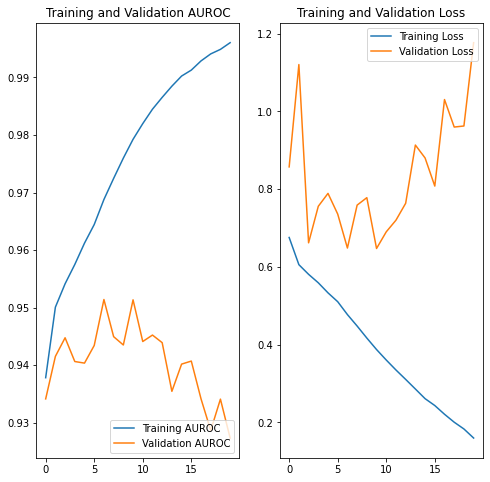

In [9]:
auroc = history.history['auroc']
val_auroc = history.history['val_auroc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(auroc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auroc, label='Training AUROC')
plt.plot(epochs_range, val_auroc, label='Validation AUROC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUROC')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Evaluate Model

In [10]:
model.evaluate(ds_test, verbose=2)

1334/1334 - 506s - loss: 0.6827 - auroc: 0.9472 - auprc: 0.8472 - accuracy: 0.8053


[0.6826754212379456,
 0.9472373127937317,
 0.8472459316253662,
 0.8053199052810669]

In [11]:
import sys
sys.path.insert(0, '/gpfs/data/paulab/nj594/ecg/scripts')
from evaluate import plot_auc_multi, plot_pr_multi

# Get y_pred 
y_pred = model.predict(ds_test)

# Get y_test
y_test = np.concatenate([y for x,y in ds_test], 0)

plot_auc_multi(y_test, y_pred, model_dir, 'diabetes_severity', sample_weight = None, split='test')
plot_pr_multi(y_test, y_pred, model_dir, 'diabetes_severity', sample_weight = None, split='test')

ModuleNotFoundError: No module named 'evaluate'

# Save Explanation Data Set

In [6]:
from tqdm.notebook import tqdm
from tensorflow.keras.applications.densenet import DenseNet121

# Load Data

(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'diabetic_retinopathy_detection/btgraham-300',
    split=['train', 'validation', 'test'],
    as_supervised=False,
    with_info=True,
)

# Load Model

base_model = DenseNet121(
    include_top=False, weights='imagenet', 
    input_shape=INPUT_SHAPE, pooling='avg'
)

base_model.summary()

model_input = Input(shape=INPUT_SHAPE, name='input')

# flipped_input = data_augmentation(model_input)
net = base_model(model_input)
out = Dense(NUM_CLASSES, activation='softmax')(net)

model = Model(model_input, out)

# Model Checkpointing
save_dir = 'model/densenet'
model_dir = os.path.join(os.getcwd(), save_dir)
model_weights_path = os.path.join(model_dir, 'model_weights.h5')

# Get Checkpointed Model
print(model_weights_path)
model.load_weights(model_weights_path)
model.trainable = False


# Metrics
METRICS = [ 
  tf.keras.metrics.AUC(name='auroc'),
  tf.keras.metrics.AUC(curve='PR', name='auprc'),
  tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='accuracy'),
]

# Compile Model
OPTIMIZER = tf.keras.optimizers.Adam(LR)

model.compile(
    loss='categorical_crossentropy',
    optimizer=OPTIMIZER,
    metrics=METRICS,
)

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 544, 544, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 550, 550, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 272, 272, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 272, 272, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

/vast/nj594/xai/diabetic_retinopathy/experiments/model/densenet/model_weights.h5


In [4]:
# Get Labels
y_val = np.array([x['label'] for x in ds_val]).squeeze()

2021-10-14 19:52:18.995058: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-14 19:52:19.015543: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2021-10-14 19:52:19.019325: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2021-10-14 19:52:19.022947: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


In [5]:
y_test = np.array([x['label'] for x in ds_test]).squeeze()

2021-10-14 19:59:21.663782: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-14 19:59:21.683633: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2021-10-14 19:59:21.687403: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2021-10-14 19:59:21.690637: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


In [6]:
# Select Images from Each Class
def select_images(ds, y, n=500):
    # Select n Indexs and Labels from each class
    y_sel = []
    sel_inds = []
    for i in range(5):
        inds = np.where(y == i)[0]
        inds = np.random.choice(inds, n, replace=False)
        sel_inds.append(inds)
        y_sel.append(np.eye(5)[y[inds]])
        
    y_sel = np.concatenate(y_sel, 0)
    sel_inds = np.concatenate(sel_inds, 0)
        
    # Select Images
    x_sel = []
    x_process = []
    for i, x in tqdm(enumerate(ds)):
        if i in sel_inds:
            x = Resizing(INPUT_SHAPE[0], INPUT_SHAPE[1], interpolation='nearest')(tf.expand_dims(x['image'], 0))
            x_p = tf.cast(x, tf.float32)
            x_p = tf.keras.applications.inception_v3.preprocess_input(x_p)
            x_sel.append(x)
            x_process.append(x_p)
    x_sel = np.vstack(x_sel)
    x_process = np.vstack(x_process)
    
    # Get Predictions 
    preds_sel = model.predict(x_process, batch_size=16, verbose=1)
    
    return sel_inds, y_sel, preds_sel, x_sel, x_process

In [6]:
# Make Selections
val_inds, y_val, pred_val, X_val, X_process_val = select_images(ds_val, y_val, n=200)

2021-10-14 19:52:27.655496: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2021-10-14 19:52:27.659209: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


0it [00:00, ?it/s]

2021-10-14 19:52:27.745475: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2021-10-14 19:52:44.809079: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2021-10-14 19:52:44.813594: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2021-10-14 19:52:44.816409: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2021-10-14 19:52:45.596660: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


63/63 [==============================] - 93s 97ms/step


In [7]:
test_inds, y_test, pred_test, X_test, X_process_test = select_images(ds_test, y_test, n=500)

2021-10-14 19:59:55.183240: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2021-10-14 19:59:55.187532: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


0it [00:00, ?it/s]

2021-10-14 19:59:55.219208: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2021-10-14 20:00:49.516926: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2021-10-14 20:00:49.520455: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2021-10-14 20:00:49.522650: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2021-10-14 20:00:50.335070: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


157/157 [==============================] - 94s 550ms/step


In [4]:
# Save
data_dir = os.path.join(os.getcwd(), 'data')
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

In [9]:
np.save(os.path.join(data_dir, 'val_inds.npy'), val_inds)    
np.save(os.path.join(data_dir, 'X_val.npy'), X_val)
np.save(os.path.join(data_dir, 'X_val_processed.npy'), X_process_val)
np.save(os.path.join(data_dir, 'y_val.npy'), y_val)
np.save(os.path.join(data_dir, 'predictions_val.npy'), pred_val)

In [9]:
np.save(os.path.join(data_dir, 'test_inds.npy'), test_inds)
np.save(os.path.join(data_dir, 'X_test.npy'), X_test)
np.save(os.path.join(data_dir, 'X_test_processed.npy'), X_process_test)
np.save(os.path.join(data_dir, 'y_test.npy'), y_test)
np.save(os.path.join(data_dir, 'predictions.npy'), pred_test)

In [6]:
from tqdm.notebook import tqdm

In [5]:
# Select Images from Each Class
def sample_images(ds, n=3000):
    # Select n Indexs and Labels from each class
    inds = np.arange(len(ds))
    sel_inds = np.random.choice(inds, n, replace=False)
        
    # Select Images
    x_sel = []
    y_sel = []
    x_process = []
    for i, x in tqdm(enumerate(ds)):
        if i in sel_inds:
            y_sel.append(np.eye(5)[x['label']])
            x = Resizing(INPUT_SHAPE[0], INPUT_SHAPE[1], interpolation='nearest')(tf.expand_dims(x['image'], 0))
            x_p = tf.cast(x, tf.float32)
            x_p = tf.keras.applications.inception_v3.preprocess_input(x_p)
            x_sel.append(x)
            x_process.append(x_p)
    x_sel = np.vstack(x_sel)
    x_process = np.vstack(x_process)
    y_sel = np.vstack(y_sel)
    
    # Get Predictions 
    preds_sel = model.predict(x_process, batch_size=16, verbose=1)
    
    return sel_inds, y_sel, preds_sel, x_sel, x_process

In [6]:
# Make Selections
val_inds, y_val, pred_val, X_val, X_process_val = sample_images(ds_val, n=1000)
test_inds, y_test, pred_test, X_test, X_process_test = sample_images(ds_test, n=3000)

2022-04-16 23:49:55.517393: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-16 23:49:55.537062: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-04-16 23:49:55.540772: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


0it [00:00, ?it/s]

2022-04-16 23:49:55.571435: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-04-16 23:50:14.395708: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-04-16 23:50:14.399244: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-04-16 23:50:14.401461: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-04-16 23:50:15.619283: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed r

MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record

MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record

 1/63 [..............................] - ETA: 12:04

MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record

62/63 [============================>.] - ETA: 0s

MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record

MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record

MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record

MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record

63/63 [==============================] - 21s 146ms/step


MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record

0it [00:00, ?it/s]

2022-04-16 23:50:35.145694: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


  2/188 [..............................] - ETA: 20s

2022-04-16 23:51:36.904231: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-04-16 23:51:36.907975: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-04-16 23:51:36.910252: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


188/188 [==============================] - 20s 108ms/step


In [7]:
np.save(os.path.join(data_dir, 'val_inds.npy'), val_inds)    
np.save(os.path.join(data_dir, 'X_val.npy'), X_val)
np.save(os.path.join(data_dir, 'X_val_processed.npy'), X_process_val)
np.save(os.path.join(data_dir, 'y_val.npy'), y_val)
np.save(os.path.join(data_dir, 'predictions_val.npy'), pred_val)

In [8]:
np.save(os.path.join(data_dir, 'test_inds.npy'), test_inds)
np.save(os.path.join(data_dir, 'X_test.npy'), X_test)
np.save(os.path.join(data_dir, 'X_test_processed.npy'), X_process_test)
np.save(os.path.join(data_dir, 'y_test.npy'), y_test) 
np.save(os.path.join(data_dir, 'predictions.npy'), pred_test)

In [7]:
X_test = np.load(os.path.join('data', 'X_test_processed.npy'))

In [8]:
from tqdm.notebook import tqdm

In [19]:
y_test = []
for i, (x, y) in tqdm(enumerate(ds_test)):
    for j, x_t in enumerate(X_test):
        inds = np.where(K.sum(x-x_t, (1,2,3))==0)[0]
        if len(inds)> 0:
            y_test.append(y.numpy()[inds])
            print(j)
        

2022-05-02 11:43:35.769905: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 11:43:35.773845: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 11:43:35.778520: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


0it [00:00, ?it/s]

2022-05-02 11:43:35.810175: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


KeyboardInterrupt: 

In [10]:
np.save(os.path.join('data', 'y_test_fixed.npy'), np.vstack(y_test))

# Load Explanation Set

In [18]:
X_process_test = np.load(os.path.join('data', 'X_test_processed.npy'))
y_test_fixed = np.load(os.path.join('data', 'y_test_fixed.npy'))
y_test = np.load(os.path.join('data', 'y_test.npy'))

In [55]:
y_pred = model.predict(X_process_test)

2022-05-02 12:12:06.395262: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 12:12:06.399116: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 12:12:06.401457: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 12:12:07.463331: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486


In [10]:
model.evaluate(X_process_test, y_test)

2022-05-02 11:38:50.664113: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-02 11:38:50.682814: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 11:38:50.686535: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 11:38:50.689262: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 11:38:53.879724: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486


79/79 [==============================] - 40s 249ms/step - loss: 4.4051 - auroc: 0.5019 - auprc: 0.2022 - accuracy: 0.2028


MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486


[4.405133247375488,
 0.5018692016601562,
 0.20223574340343475,
 0.20280000567436218]

In [11]:
model.evaluate(X_process_test, y_test_fixed)

2022-05-02 11:39:48.822252: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 11:39:48.826143: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 11:39:48.829082: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


79/79 [==============================] - 19s 241ms/step - loss: 2.1291 - auroc: 0.7212 - auprc: 0.3602 - accuracy: 0.3496


[2.129081964492798,
 0.7212352752685547,
 0.36015576124191284,
 0.3495999872684479]

In [14]:
y_pred_test = model.predict(ds_test)

2022-05-02 11:47:42.385175: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 11:47:42.388975: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 11:47:42.393570: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 11:47:42.408657: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 11:47:42.412569: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 11:47:42.417224: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 11:47:43.509530: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 11:47:43.556658: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.t

MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record

MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record

MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record

MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record

MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record

MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record

MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record

MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record

In [16]:
y_test_all = np.vstack([y for x, y in ds_test])

2022-05-02 11:58:11.696080: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 11:58:11.699912: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 11:58:11.704430: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 11:58:11.708618: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


In [15]:
from sklearn.metrics import roc_auc_score

In [66]:
# Select n Indexs and Labels from each class
y_sel_pred = []
y_sel_test = []
sel_inds = []
for i in range(5):
    inds = np.where(y_test_all[:,i] == 1)[0]
    inds = np.random.choice(inds, 500, replace=False)
    y_sel_pred.append(y_pred_test[inds])
    y_sel_test.append(y_test_all[inds])

y_sel_pred = np.concatenate(y_sel_pred, 0)
y_sel_test = np.concatenate(y_sel_test, 0)

In [59]:
roc_auc_score(y_test_fixed, y_pred, average=None)

array([0.866298, 0.696998, 0.639849, 0.819321, 0.878345])

In [67]:
roc_auc_score(y_sel_test, y_sel_pred, average=None)

array([0.845029 , 0.6701805, 0.6162725, 0.7583725, 0.8446235])

In [16]:
for i, (x, y) in tqdm(enumerate(ds_test)):
    print(x.shape)
    break

2022-05-02 11:19:24.787542: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 11:19:24.791915: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-02 11:19:24.796370: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


0it [00:00, ?it/s]

2022-05-02 11:19:24.827737: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


(512, 544, 544, 3)


In [15]:
len(X_test)

2500

In [17]:
(X_test[:, None] == x).all(-1).any(-1)

2022-05-02 11:20:01.145580: W tensorflow/core/common_runtime/bfc_allocator.cc:457] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.03TiB (rounded to 1136394240000)requested by op Equal
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-05-02 11:20:01.145616: I tensorflow/core/common_runtime/bfc_allocator.cc:1004] BFCAllocator dump for GPU_0_bfc
2022-05-02 11:20:01.145625: I tensorflow/core/common_runtime/bfc_allocator.cc:1011] Bin (256): 	Total Chunks: 101, Chunks in use: 100. 25.2KiB allocated for chunks. 25.0KiB in use in bin. 3.2KiB client-requested in use in bin.
2022-05-02 11:20:01.145632: I tensorflow/core/common_runtime/bfc_allocator.cc:1011] Bin (512): 	Total Chunks: 255, Chunks in use: 255. 133.0KiB allocated for chunks. 133.0KiB in use in bin. 129.1KiB client-requested in use in bin.
2022-05-02 11:20:01.14

ResourceExhaustedError: failed to allocate memory [Op:Equal]

In [37]:
X_test = X_test.reshape((X_test.shape[0], -1))

In [49]:
X_test == x

/ext3/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

In [51]:
x.shape

(512, 887808)

In [50]:
X_test.shape

(2500, 887808)

In [33]:
x = x.numpy().reshape((x.shape[0], -1))

In [28]:
a = np.array([[1,0],[2,0],[3,1],[4,2]])
b = np.array([[1,0],[2,0],[4,2]])

In [56]:
a[:, None].shape

(4, 1, 2)

In [57]:
a[:, None] == b

array([[[ True,  True],
        [False,  True],
        [False, False]],

       [[False,  True],
        [ True,  True],
        [False, False]],

       [[False, False],
        [False, False],
        [False, False]],

       [[False, False],
        [False, False],
        [ True,  True]]])

In [54]:
a.shape

(4, 2)

In [55]:
b.shape

(3, 2)

In [7]:
# Load Evaluator Model
print('Loading Evaluator')

eval_dir = 'evaluation/evaluator-data'
evaluator_model = tf.keras.models.load_model(os.path.join(eval_dir, 'surrogate.h5'))

OPTIMIZER = tf.keras.optimizers.Adam(1e-3)
METRICS = [ 
  tf.keras.metrics.AUC(name='auroc'),
  tf.keras.metrics.AUC(curve='PR', name='auprc'),
  tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='accuracy'),
]

evaluator_model.compile(
    loss='categorical_crossentropy',
    optimizer=OPTIMIZER,
    metrics=METRICS,
)

Loading Evaluator


In [14]:
evaluator_model.evaluate(ds_test, verbose=2)

2022-05-11 16:55:29.456447: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-11 16:55:29.460105: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-11 16:55:29.464370: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-11 16:55:29.655600: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-11 16:55:29.659984: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-11 16:55:29.664374: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-11 16:55:31.181149: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-11 16:55:31.242007: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.t

MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record

MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record: key not found: /home/nj594/.config/miopen//gfx906_60.HIP.2_11_0_.ufdb.txt#486
MIOpen(HIP): Error [FindRecordUnsafe] Ill-formed record

167/167 - 306s - loss: 0.5965 - auroc: 0.9512 - auprc: 0.8498 - accuracy: 0.8126


[0.5965200066566467,
 0.9511622190475464,
 0.8498117923736572,
 0.8126083612442017]

In [30]:
y_eval = evaluator_model.predict(X_process_test*1., verbose=2)

2022-05-15 20:42:17.428195: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-15 20:42:17.432031: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-15 20:42:17.434378: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


79/79 - 16s


In [20]:
y_model = model.predict(X_process_test, verbose=2)

2022-05-15 20:39:02.265987: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-15 20:39:02.269785: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-15 20:39:02.272128: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-05-15 20:39:03.944353: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


79/79 - 18s


In [31]:
(y_eval * y_test_fixed).sum(1).mean()

/ext3/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

In [37]:
np.exp((np.log(y_eval) * y_test_fixed).sum(1).mean())

0.22390907

In [38]:
np.exp((np.log(y_model) * y_test_fixed).sum(1).mean())

0.11894639